# 1. 环境搭建

In [165]:
!nvidia-smi

Wed May  7 19:32:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   48C    P8             15W /  450W |    1025MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [166]:
# # Connect to drive
# from google.colab import drive
# drive.mount('/content/drive')

In [167]:
# !pip install ultralytics
# !pip install roboflow

In [168]:
# Libraries import
import ultralytics
import torch
import cv2

# 2. 数据集准备

关于数据集格式的说明：标签以 YOLO 格式导出，保存为 \*.txt 文件。

如果图像中没有目标对象，则不需要创建 \*.txt 文件。 \*.txt 文件的格式为每个目标对象一行，格式为 `[类别, x_center, y_center, 宽度, 高度]`。边界框的坐标是归一化的 `[x, y, w, h]` 格式（范围从 0 到 1）。

后面的代码是以像素为单位测量的，将 `x_center` 和 `宽度` 除以图像的宽度，将 `y_center` 和 `高度` 除以图像的高度。类别编号为从 0 开始的索引（即从 0 开始计数）。

In [169]:
import os
os.chdir("E://bmx/YoloCAM")
print("work path:", os.getcwd())

work path: E:\bmx\YoloCAM


In [170]:
# Download dataset
# from roboflow import Roboflow
# rf = Roboflow(api_key="BoQfQxmvaqg6UKV9Ht16")
# project = rf.workspace("vietnam-traffic-sign-detection").project("vietnam-traffic-sign-detection-2i2j8")
# version = project.version(6)
# dataset = version.download("yolov8")
# ! mkdir ./mask-attack
# ! mv ./Vietnam-Traffic-Sign-Detection-6 ./mask-attack/datasets

# 3. 训练检测器
该数据集取自 Roboflow，包含 3680 张图像。它被划分为 2280 张训练图像、786 张验证图像和 614 张测试图像。

In [171]:
# # training medium version of YOLOv8

# from ultralytics.models.yolo.detect.train import DetectionTrainer
# from ultralytics import YOLO

# args = dict(model="yolov8m.pt", data="./mask-attack/datasets/data.yaml", epochs=100, batch=33)
# trainer = DetectionTrainer(overrides=args)
# trainer.train()

In [172]:
# #Save pretrained model to drive
# import shutil

# path = '/content/drive/MyDrive/YOLOv9-AdversarialAttack/yolov8_official_2'

# shutil.copytree('/content/runs', path)

导入训练好的检测器

In [173]:
from ultralytics import YOLO
from ultralytics.models.yolo.detect.train import DetectionTrainer

args = dict(model="yolov8m.pt", data="./mask-attack/data.yaml")
trainer = DetectionTrainer(overrides=args)
trainer.setup_model()
trainer.set_model_attributes()
trainer.model.eval()

Ultralytics 8.3.119  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=./mask-attack/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

In [174]:
from pathlib import Path
from PIL import Image

def check_image_sizes(folder_path):
    """
    Check the dimensions of all .jpg images in a folder and return a list of all found dimensions.

    Args:
        folder_path (str): Path to the image folder

    Returns:
        tuple: (whether all images have the same dimensions, list of all found dimensions)
    """
    folder = Path(folder_path)
    if not folder.is_dir():
        raise ValueError(f"{folder_path} is not a valid folder path")
    sizes = set()  # Use a set to automatically remove duplicates
    inconsistent = False
    # Iterate through all .jpg files in the folder
    for img_path in folder.glob("*.jpg"):
        try:
            with Image.open(img_path) as img:
                sizes.add(img.size)  # img.size returns (width, height)
        except Exception as e:
            print(f"Unable to read image {img_path}: {e}")
            continue
    # Check if all images have the same dimensions
    all_same = len(sizes) == 1
    return all_same, sorted(sizes)  # Return a sorted list of dimensions

# # Initialize result lists
# is_consistent = []
# size_lists = []
# # Check image dimensions in three folders
# for folder_name in [
#     "./mask-attack/datasets/valid/images",
#     "./mask-attack/datasets/test/images",
#     "./mask-attack/datasets/train/images"
# ]:
#     consistent, sizes = check_image_sizes(folder_name)
#     is_consistent.append(consistent)  # Append to the result list
#     size_lists.append(sizes)
# # Output the results
# if all(is_consistent):
#     print(f"All images have the same dimensions: {size_lists[0][0]}")
# else:
#     print(f"Image dimensions are inconsistent. A total of {sum(len(size_list) for size_list in size_lists)} different dimensions were found:")
#     for size_list in size_lists:
#         for size in size_list:
#             print(f"- {size[0]}x{size[1]}")


`CustomDataset` is a PyTorch Dataset class designed for processing object detection datasets in YOLO format. It automatically pairs images with their corresponding labels and provides the following functionalities: loading images and converting them into normalized tensors (C,H,W format with value range [0,1]), parsing YOLO-format txt label files, converting YOLO relative coordinates to absolute pixel coordinates, and generating binary masks for target regions.

To use it, simply specify the paths to the image and label directories along with the desired image dimensions. The `__getitem__` method returns a dictionary containing the image tensor, original labels, class IDs, bounding boxes, and masks, making it directly compatible with DataLoader for batch loading.

Typical usage includes initializing the dataset and accessing samples via indexing, or combining it with DataLoader for batch training. For visualization, note that tensors need to be converted back to HWC format and the coordinate system should be restored.

In [175]:
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
from ultralytics.utils.loss import v8DetectionLoss
import cv2
import numpy as np

In [176]:
class CustomDataset(Dataset):
    def __init__(self, images_dir_path, labels_dir_path, image_width, image_height):
        """
        self.image_paths is a list containing the paths of all image files.
        self.label_paths is a list containing the paths of all label files,
        with each label file path corresponding one-to-one with the respective image file path.
        """
        super().__init__()
        self.image_paths = sorted(Path(images_dir_path).glob('*.png'), key=lambda x: x.stem)
        self.label_paths = [Path(labels_dir_path)/f'{p.stem}.txt' for p in self.image_paths]
        self.origin_images_dir_path = images_dir_path 
        self.origin_labels_dir_path = labels_dir_path

        self.image_width = image_width
        self.image_height = image_height
        
    def __len__(self):
        return len(self.image_paths)

    def load_image(self, img_path):
        img_path = str(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, dsize=(self.image_width, self.image_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        # Adjust the dimension order (from (height, width, channels) to (channels, height, width))
        # and normalize the pixel values to the range of [0, 1].
        img = torch.tensor(img).permute(2,0,1) / 255.0  # Normalize and permute dimensions
        return img

    def load_label(self, labels_path):
        labels = torch.tensor([list(map(float, line.split())) for line in open(labels_path)])
        return labels

    def yolo_to_pixel(self, yolo_bboxes):
        """Convert YOLO format [xc,yc,w,h] to pixel coordinates [xmin,ymin,xmax,ymax]"""
        xc = yolo_bboxes[:, 0] * self.image_width
        yc = yolo_bboxes[:, 1] * self.image_height
        w = yolo_bboxes[:, 2] * self.image_width
        h = yolo_bboxes[:, 3] * self.image_height

        x_min = xc - w/2
        y_min = yc - h/2
        x_max = xc + w/2
        y_max = yc + h/2

        return torch.stack([x_min, y_min, x_max, y_max], dim=1)

    def convert_yolo_to_batch_format_torch(self, labels, idx):
        """
        Convert YOLO format labels to batch-compatible format for detection tasks

        Args:
            idx (int): Sample index in dataset

        Returns:
            tuple: (batch_indices, classes, bboxes) as torch.Tensor or None if empty
        """
        if labels.numel() == 0:
            return (
            torch.empty(0, 1, dtype=torch.long),
            torch.empty(0, 1, dtype=torch.long),
            torch.empty(0, 4, dtype=torch.float32)
        )
        classes = labels[:, 0].long()
        bboxes = self.yolo_to_pixel(labels[:, 1:5])
        classes = classes.unsqueeze(1)
        batch_indices = torch.tensor([idx]).unsqueeze(0).expand(classes.size(0), -1)
        # print(classes.size() == batch_indices.size())
        return batch_indices, classes, bboxes

    def generate_mask(self, bboxes):
        """
        Generate binary mask for object regions from bounding bboxes

        Args:
            bboxes (torch.Tensor): Bounding bboxes in [xmin, ymin, xmax, ymax] format,
                                shape: (N, 4) where N is number of bboxes

        Returns:
            torch.Tensor: Binary mask of shape (image_height, image_width)
                        where 1 indicates object regions
        """
        # Initialize empty mask
        mask = torch.zeros((self.image_height, self.image_width),
                          dtype=torch.float32,
                          device=bboxes.device if torch.is_tensor(bboxes) else None)

        # Early return if no bboxes
        if bboxes.numel() == 0:
            return mask.unsqueeze(0).expand(3, -1, -1)
        # Convert coordinates to integers and clamp to image boundaries
        """Bounding Boxes example:
        [[378.2500, 384.5000, 398.7500, 415.5000],
        [220.5000, 424.5000, 226.5000, 435.5000],
        [227.0000, 424.7500, 233.0000, 436.2500]]
        """
        bboxes = bboxes.clone().detach()  # Avoid modifying original tensor
        bboxes[:, [0, 2]] = bboxes[:, [0, 2]].clamp(0, self.image_width - 1)
        bboxes[:, [1, 3]] = bboxes[:, [1, 3]].clamp(0, self.image_height - 1)
        bboxes = bboxes.int()  # Convert to integer indices

        # Vectorized implementation (faster than loop for multiple bboxes)
        for xmin, ymin, xmax, ymax in bboxes:
            mask[ymin:ymax+1, xmin:xmax+1] = 1

        return mask.unsqueeze(0).expand(3, -1, -1)

    def __getitem__(self, idx):
        img = self.load_image(self.image_paths[idx])
        labels = self.load_label(self.label_paths[idx])
        image_path = self.image_paths[idx]
        labels_path = self.label_paths[idx]
        batch_indices, classes, bboxes = self.convert_yolo_to_batch_format_torch(labels, idx)
        mask = self.generate_mask(bboxes)
        dict = {
          "image": img,
          "labels": labels,
          "image_path": image_path,
          "labels_path": labels_path,
          "batch_indices": batch_indices,
          "classes": classes,
          "bboxes": bboxes,
          "mask": mask
        }
        # print("path: ", self.label_paths[idx])
        return dict

10


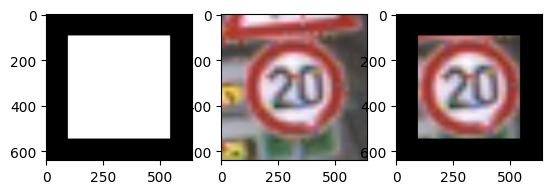

In [177]:
images_dir_path = "./datasets/gtsrb_origin/0/images"
labels_dir_path = "./datasets/gtsrb_origin/0/labels"
# Initialize dataset
train_dataset = CustomDataset(images_dir_path = images_dir_path, 
                              labels_dir_path = labels_dir_path,
                              image_width=640,
                              image_height=640)
print(len(train_dataset))
sample_data = train_dataset[0]

import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(sample_data["mask"][0, :, :], cmap='gray')
# img.size()
plt.subplot(132)
masked_img = sample_data["image"]
plt.imshow(masked_img.permute(1, 2, 0))
plt.subplot(133)
masked_img = sample_data["image"] * sample_data["mask"]
plt.imshow(masked_img.permute(1, 2, 0))
plt.show()

**TODO** 改进掩码的形状，使其更接近真实样本形状

为了方便这里直接把空标签样本滤除了

# 5. 攻击实现

`Attacker` 类是一个用于对 YOLOv8 检测模型进行对抗攻击的工具，实现了 **FGSM（快速梯度符号法）**、**PGD（投影梯度下降法）** 及其 **带掩码版本** 的攻击方法，以生成对抗样本。以下是该类的核心功能描述：

1. **攻击方法**：
   - **FGSM/PGD**：通过计算模型损失相对于输入图像的梯度生成对抗扰动。
   - **带掩码攻击**：利用提供的掩码限制扰动区域（例如仅针对目标边界框内的区域进行攻击）。
   - **批量处理**：支持以批处理方式高效处理数据集，并将结果保存到有序目录中**（没完全实现出来）**。

2. **工作流程**：
   - 使用 `compute_gradient()` 或 `compute_masked_gradient()` 方法计算输入图像的梯度。
   - 通过 `fgsm()`、`masked_fgsm()`、`pgd()` 和 `masked_pgd()` 方法应用扰动生成对抗样本。
   - 将生成的对抗样本和对应标签文件保存到结构化的输出路径（例如，`./mask-attack/method/eps-0.5/` 表示 FGSM 攻击，ε=0.5 的结果）。

3. **主要特性**：
   - **参数化攻击**：支持可调参数，如 `epsilon`（扰动大小）、`alpha`（步长）和 `num_iter`（迭代次数）。
   - **自动化存储**：根据攻击方法、参数和数据集结构组织输出结果。
   - **可扩展性**：预留了对抗训练接口（`adversarial_training()`），方便未来扩展功能。

该类旨在通过对检测模型生成对抗样本来系统评估其鲁棒性，同时保持易用性，支持批量处理和结构化输出管理，便于实验结果的管理和分析。

In [178]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    """
    Custom collate function to handle batch processing with padding.
    
    Filters out samples with empty labels and returns a batch dictionary.
    
    Args:
        batch (list): List of dictionaries containing image, mask, labels, etc.
        
    Returns:
        dict: Batched data with padded sequences, or None if all samples are filtered out.
    """
    # Filter out samples with empty labels
    batch = [sample for sample in batch if len(sample["labels"]) > 0]
    if len(batch) == 0:
        return None  # Return None if no valid samples remain

    # Initialize lists to collect batch data
    images = []
    masks = []
    image_path = []
    labels_path = []
    labels = []
    batch_indices = []
    classes = []
    bboxes = []

    # Collect data from each sample
    for sample in batch:
        images.append(sample["image"])
        masks.append(sample["mask"])
        image_path.append(sample["image_path"])  # Fix variable name: "image_path"
        labels_path.append(sample["labels_path"])
        labels.append(torch.tensor(sample["labels"]).clone().detach())
        batch_indices.append(torch.tensor(sample["batch_indices"]).clone().detach())
        classes.append(torch.tensor(sample["classes"]).clone().detach())
        bboxes.append(torch.tensor(sample["bboxes"]).clone().detach())

    # Stack tensors for images and masks (same size)
    images = torch.stack(images, dim=0)  # Shape: (B, C, H, W)
    # masks = torch.stack(masks, dim=0)    # Shape: (B, C, H, W)
    masks = pad_sequence(masks, batch_first=True, padding_value=0)  # Pad masks to the same size
    masks = masks.view(len(batch), 3, 640, 640)  # Reshape back to (B, C, H, W)

    # Pad sequences for labels, batch_indices, classes, and bboxes
    labels = pad_sequence(labels, batch_first=True, padding_value=-1)          # Shape: (B, N_max, D_labels)
    batch_indices = pad_sequence(batch_indices, batch_first=True, padding_value=-1)  # Shape: (B, N_max, 1)
    classes = pad_sequence(classes, batch_first=True, padding_value=-1)        # Shape: (B, N_max, 1)
    bboxes = pad_sequence(bboxes, batch_first=True, padding_value=-1)          # Shape: (B, N_max, 4)

    # Return batch dictionary
    return {
        "image": images,
        "mask": masks,
        "image_path": image_path,  # Add image paths
        "labels_path": labels_path,  # Add label paths
        "labels": labels,
        "batch_indices": batch_indices,
        "classes": classes,
        "bboxes": bboxes
    }

In [ ]:
import os
import shutil
from PIL import Image
from tqdm import tqdm
from itertools import islice

class Attacker:
    def __init__(self, trainer, dataset, batch_size=1, custom_collate_fn=None):
        """
        Initialize the Attacker
        
        Args:
        """
        self.trainer = trainer
        self.dataset = dataset
        self.custom_collate_fn = custom_collate_fn or torch.utils.data.default_collate
        self.batch_size = batch_size
        self.attack_fuction = None
        # ** 

    def compute_gradient(self, image):
        # Ensure gradients are enabled for the input image
        image.requires_grad = True
        # Forward pass through the model (add batch dimension)
        pred = self.trainer.model(image.unsqueeze(0))
        # Prepare dummy labels dictionary for loss computation
        labels_dict = {
            'batch_idx': torch.tensor([[0]]),  # Dummy label for batch index
            'cls': torch.tensor([[0]]),       # Dummy class label
            'bboxes': torch.tensor([[0, 0, 1, 1]])  # Dummy bounding box
        }
        # Compute the loss (assuming you have a predefined loss function)
        loss_fn = v8DetectionLoss(self.trainer.model)
        loss, _ = loss_fn(pred, labels_dict)
        # Zero out any existing gradients
        self.trainer.model.zero_grad()
        # print(f"Loss before backward: {loss}, Shape: {loss.shape}")
        # Backward pass to compute gradients
        loss = loss.sum()
        loss.backward()
        # Extract the gradient of the input image
        gradient = image.grad.data
        
        return gradient
        
    def compute_masked_gradient(self, image, mask):
        # Ensure gradients are enabled for the input image
        image.requires_grad = True
        # Forward pass through the model (add batch dimension)
        pred = self.trainer.model(image.unsqueeze(0))  # Add batch dimension
        # Prepare dummy labels dictionary for loss computation
        labels_dict = {
            'batch_idx': torch.tensor([[0]]),  # Dummy label for batch index
            'cls': torch.tensor([[0]]),       # Dummy class label
            'bboxes': torch.tensor([[0, 0, 1, 1]])  # Dummy bounding box
        }
        # Compute the loss (assuming you have a predefined loss function)
        loss_fn = v8DetectionLoss(self.trainer.model)
        loss, _ = loss_fn(pred, labels_dict)
        loss = loss.sum()
        # Zero out any existing gradients
        self.trainer.model.zero_grad()
        # Backward pass to compute gradients
        loss = loss.sum()
        loss.backward()
        # Extract the gradient of the input image
        gradient = image.grad.data
        # Apply the mask to the gradient
        masked_gradient = gradient * mask
        return masked_gradient
    
    def fgsm(self, image, epsilon):
        gradient = self.compute_gradient(image)
        if gradient is None:
            return None
        sign_data_grad = gradient.sign()
        perturbed_img = image + epsilon * gradient * sign_data_grad
        perturbed_img = torch.clamp(perturbed_img, 0, 1)
        return perturbed_img

    def masked_fgsm(self, image, epsilon, mask):
        # Compute the masked gradient
        masked_gradient = self.compute_masked_gradient(image, mask)
        if masked_gradient is None:
            return None
        # Calculate the sign of the masked gradient
        sign_data_grad = masked_gradient.sign()
        perturbed_img = image + epsilon * masked_gradient * sign_data_grad
        perturbed_img = torch.clamp(perturbed_img, 0, 1)
        return perturbed_img

    def pgd(self, image, epsilon, alpha, num_iter):
        """
        Projected Gradient Descent (PGD) attack implementation.
        Args:
            image (torch.Tensor): Input image tensor (C, H, W).
            epsilon (float): Maximum perturbation magnitude.
            alpha (float): Step size for each iteration.
            num_iter (int): Number of PGD iterations.
        Returns:
            torch.Tensor: Adversarial perturbed image.
        """
        perturbed_image = image.clone().detach().requires_grad_(True)
        for _ in range(num_iter):
            gradient = self.compute_gradient(perturbed_image)
            # Update perturbed image using FGSM-style step
            perturbed_image = perturbed_image + alpha * gradient.sign()
            # Project back to the epsilon-ball and [0, 1] range
            delta = torch.clamp(perturbed_image - image, -epsilon, epsilon)
            perturbed_image = torch.clamp(image + delta, 0, 1).detach().requires_grad_(True)
        return perturbed_image
    
    def masked_pgd(self, image, epsilon, alpha, num_iter, mask):
        perturbed_image = image.clone().detach().requires_grad_(True)
        for _ in range(num_iter):
            gradient = self.compute_masked_gradient(perturbed_image, mask)
            # Update perturbed image using FGSM-style step
            perturbed_image = perturbed_image + alpha * gradient.sign()
            # Project back to the epsilon-ball and [0, 1] range
            delta = torch.clamp(perturbed_image - image, -epsilon, epsilon)
            perturbed_image = torch.clamp(image + delta, 0, 1).detach().requires_grad_(True)
        return perturbed_image
    
    def batch_attack(self, method, **kwargs):
        """
        Perform a batch-wise adversarial attack using the specified method.

        Args:
            epsilon (float): Perturbation magnitude.
            method (str): Attack method to use (e.g., "fgsm_attack", "masked_fgsm_attack").
        """
        # Define available attack methods
        attack_methods = {
            "fgsm": self.fgsm,
            "masked_fgsm": self.masked_fgsm,
            "pgd": self.pgd,
            "masked_pgd": self.masked_pgd
        }
        # Validate the chosen attack method
        if method not in attack_methods:
            raise ValueError(f"Unsupported attack method: {method}. "
                             f"Available methods are: {list(attack_methods.keys())}")
        # Get the selected attack function
        self.attack_function = attack_methods[method]
        print(f"Using attack method: {method}")

        # Create DataLoader for batch processing
        loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.custom_collate_fn)
        loader_with_progress = tqdm(loader, desc="Processing Batches", total=len(loader))

        # Process each batch
        for batch in loader_with_progress:
            if batch is None:  # Skip empty batches
                continue

            img_batch = batch["image"]          # Shape: (B, C, H, W)
            mask_batch = batch["mask"]          # Shape: (B, C, H, W)
            image_paths = batch["image_path"]
            label_paths = batch["labels_path"]

            # Process each sample in the batch
            for i in range(len(img_batch)):
                # 待修改！！！！！！！！！！！！！！！！！！！！
                image = img_batch[i]            # Single sample image, shape (C, H, W)
                mask = mask_batch[i]            # Single sample mask, shape (C, H, W)
                original_image_path = image_paths[i]
                original_label_path = label_paths[i]

                # Perform the attack on the single sample
                if method == "fgsm":
                    perturbed_img = self.attack_function(image, kwargs["epsilon"])
                elif method == "masked_fgsm":
                    perturbed_img = self.attack_function(image, kwargs["epsilon"], mask)
                elif method == "pgd":
                    perturbed_img = self.attack_function(image, kwargs["epsilon"], kwargs["alpha"], kwargs["num_iter"])
                elif method == "masked_pgd":
                    perturbed_img = self.attack_function(image, kwargs["epsilon"], kwargs["alpha"],
                                                         kwargs["num_iter"], mask)
                else:
                    pass

                # Save perturbed images and copy label files
                # if method == "fgsm" or method == "masked_fgsm":
                #     custom_image_path = os.path.join('./mask-attack', method, f'eps-{kwargs["epsilon"]}', 
                #                                  os.path.relpath(original_image_path, start='./mask-attack/datasets'))
                #     custom_labels_path = os.path.join('./mask-attack', method, f'eps-{kwargs["epsilon"]}',
                #                                       os.path.relpath(original_label_path, start='./mask-attack/datasets'))
                # elif method == "pgd" or method == "masked_pgd":
                #     custom_image_path = os.path.join('./mask-attack', method, f'eps-{kwargs["epsilon"]}-alpha{kwargs["alpha"]}-iter{kwargs["num_iter"]}', 
                #                                  os.path.relpath(original_image_path, start='./mask-attack/datasets'))
                #     custom_labels_path = os.path.join('./mask-attack', method, f'eps-{kwargs["epsilon"]}-alpha{kwargs["alpha"]}-iter{kwargs["num_iter"]}',
                #                                       os.path.relpath(original_label_path, start='./mask-attack/datasets'))
                # else:
                #     pass
                
                os.makedirs(os.path.dirname('./mask-attack/result/images'), exist_ok=True)
                os.makedirs(os.path.dirname('./mask-attack/result/labels'), exist_ok=True)
                
                custom_image_path = os.path.join('./mask-attack/result/images', os.path.basename(original_image_path))
                custom_labels_path = os.path.join('./mask-attack/result/labels', os.path.basename(original_label_path))

                # Process perturbed image
                perturbed_img_np = (perturbed_img * 255).clamp(0, 255).byte().cpu().numpy()  # Scale and convert to uint8

                # Rearrange dimensions if necessary
                if perturbed_img_np.shape[0] == 1:  # Grayscale image
                    perturbed_img_np = perturbed_img_np.squeeze(0)  # Remove channel dimension
                    mode = 'L'
                elif perturbed_img_np.shape[0] == 3:  # RGB image
                    perturbed_img_np = perturbed_img_np.transpose(1, 2, 0)  # Rearrange to (H, W, C)
                    mode = 'RGB'
                else:
                    raise ValueError(f"Unsupported image shape: {perturbed_img_np.shape}")
				
                Image.fromarray(perturbed_img_np, mode=mode).save(custom_image_path)
                shutil.copy2(original_label_path, custom_labels_path)

                loader_with_progress.set_postfix({
                    "Image": os.path.basename(custom_image_path),
                    "Label": os.path.basename(custom_labels_path)
                })

        print("Batch-wise masked FGSM attack completed and results saved.")

    
    def adversarial_training(self):
        pass

## 5.1 单张攻击 

对比发现，对于大型并且颜色较为单一的目标，需要较大的`epsilon`

In [ ]:
images_dir_path = "./datasets/gtsrb_origin/0/images"
labels_dir_path = "./datasets/gtsrb_origin/0/labels"

train_dataset = CustomDataset(images_dir_path = images_dir_path, 
                              labels_dir_path = labels_dir_path,
                              image_width=640,
                              image_height=640)

attacker = Attacker(
    trainer = trainer,
    dataset = train_dataset,
    batch_size = 1,
    custom_collate_fn=custom_collate_fn
)

In [181]:
%matplotlib inline
img_1 = train_dataset[4]["image"]
mask_1 = train_dataset[4]["mask"]
img_2 = train_dataset[-2]["image"]
mask_2 = train_dataset[-2]["mask"]

原图(左小目标，右大目标)

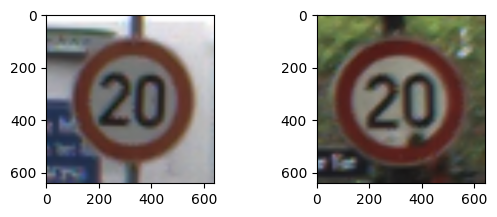

In [182]:
plt.subplot(221)
plt.imshow(img_1.permute(1, 2, 0).detach().numpy())
plt.subplot(222)
plt.imshow(img_2.permute(1, 2, 0).detach().numpy())
plt.show()

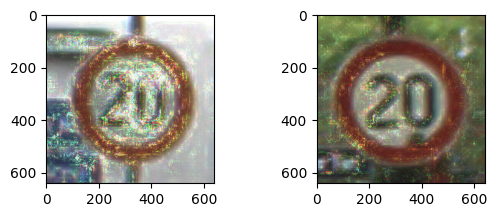

In [183]:
perturbed_1 = attacker.fgsm(img_1, epsilon=10.0)
perturbed_2 = attacker.fgsm(img_2, epsilon=10.0)
plt.subplot(221)
plt.imshow(perturbed_1.permute(1, 2, 0).detach().numpy())
plt.subplot(222)
plt.imshow(perturbed_2.permute(1, 2, 0).detach().numpy())
plt.show()

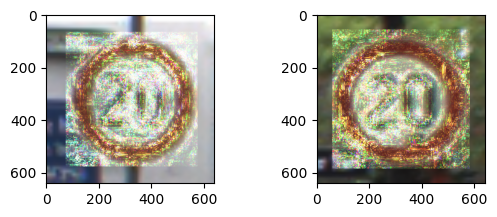

In [184]:
perturbed_1 = attacker.masked_fgsm(img_1, epsilon=10.0, mask=mask_1)
perturbed_2 = attacker.masked_fgsm(img_2, epsilon=20.0, mask=mask_2)
plt.subplot(221)
plt.imshow(perturbed_1.permute(1, 2, 0).detach().numpy())
plt.subplot(222)
plt.imshow(perturbed_2.permute(1, 2, 0).detach().numpy())
plt.show()

In [185]:
# plt.imsave(fname="./mask-attack/origin_img_2.jpg", arr=img_2.permute(1, 2, 0).detach().numpy())
# plt.imsave(fname="./mask-attack/perturbed_img_2.jpg", arr=perturbed_2.permute(1, 2, 0).detach().numpy())
# plt.imsave(fname="./mask-attack/origin_img_1.jpg", arr=img_1.permute(1, 2, 0).detach().numpy())
# plt.imsave(fname="./mask-attack/perturbed_img_1.jpg", arr=perturbed_1.permute(1, 2, 0).detach().numpy())

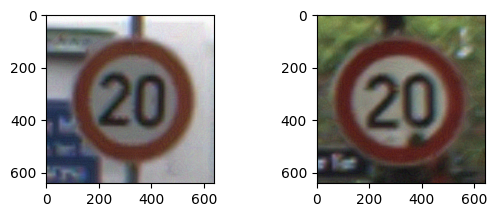

In [186]:
perturbed_1 = attacker.pgd(img_1, epsilon=1.0, alpha=0.01, num_iter=10)
perturbed_2 = attacker.pgd(img_2, epsilon=1.0, alpha=0.01, num_iter=10)
plt.subplot(221)
plt.imshow(perturbed_1.permute(1, 2, 0).detach().numpy())
plt.subplot(222)
plt.imshow(perturbed_2.permute(1, 2, 0).detach().numpy())
plt.show()

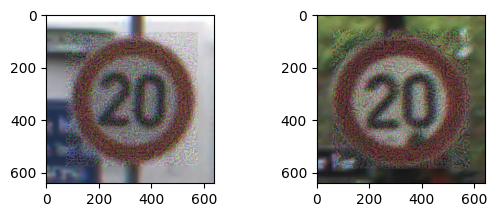

In [187]:
perturbed_1 = attacker.masked_pgd(img_1, epsilon=0.3, alpha=0.1, num_iter=10, mask=mask_1)
perturbed_2 = attacker.masked_pgd(img_2, epsilon=0.3, alpha=0.1, num_iter=10, mask=mask_2)
plt.subplot(221)
plt.imshow(perturbed_1.permute(1, 2, 0).detach().numpy())
plt.subplot(222)
plt.imshow(perturbed_2.permute(1, 2, 0).detach().numpy())
plt.show()

## 5.2 批量攻击(这里不是真批量，存在问题，导致速度很慢)

批量攻击数据集，并将结果存入`/mask_attack/custom_datasets`，存储格式与原数据集保持一致

In [208]:
# TEST Attack: PGD
images_dir_path = "./datasets/gtsrb_origin/39/images"
labels_dir_path = "./datasets/gtsrb_origin/39/labels"

train_dataset = CustomDataset(images_dir_path = images_dir_path, 
                              labels_dir_path = labels_dir_path,
                              image_width=640,
                              image_height=640)

attacker = Attacker(
    trainer = trainer,
    dataset = train_dataset,
    batch_size = 1,
    custom_collate_fn=custom_collate_fn
)

In [209]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    attacker.batch_attack(method="masked_pgd", epsilon=0.3, alpha=0.1, num_iter=10)
    # attacker.batch_attack(method="masked_fgsm", epsilon=0.8)

Using attack method: masked_pgd


Processing Batches: 100%|██████████| 10/10 [03:05<00:00, 18.55s/it, Image=00039_00009_00006.png, Label=00039_00009_00006.txt]

Batch-wise masked FGSM attack completed and results saved.


## 5.3 攻击可视化

可选内容

In [191]:
model = YOLO("./mask-attack/best.pt")
origin_dataset = test_dataset
attacked_dataset = CustomDataset(images_dir_path = "./mask-attack/masked_fgsm/eps-1.0/test/images",
                              labels_dir_path = "./mask-attack/masked_fgsm/eps-1.0/test/labels",
                              image_width=640,
                              image_height=640)

FileNotFoundError: [Errno 2] No such file or directory: 'mask-attack\\best.pt'

In [ ]:
# 绘图相关代码，不用动
def draw_boxes(img, predictions, ax, title=""):
    img = img.detach().cpu().numpy()  # Convert tensor to numpy array
    img = np.transpose(img, (1, 2, 0))  # Change the order of dimensions
    img = np.clip(img, 0, 1) * 255  # Convert image back to pixel range [0, 255]
    img = img.astype(np.uint8)  # Convert to uint8 for cv2
    
    print(f'{title}: pred result:')
    
    for pred in predictions:
        box = pred['box']
        score = pred['score']
        label = pred['label']

        # Draw bounding box
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)

        # Modify text parameters here:
        text = f'{label} ({score:.2f})'
        print(text)
        font_scale = 0.8  # 原值是0.5，调大数值可增大字体（例如改为0.8或1.0）
        thickness = 2     # 字体边框粗细，可与font_scale配合调整

        # 使用更清晰的字体（可选）
        font = cv2.FONT_HERSHEY_DUPLEX  # 原默认是cv2.FONT_HERSHEY_SIMPLEX

        img = cv2.putText(
            img,
            text,
            (int(box[0]), int(box[1]) - 10),
            font,           # 使用新字体
            font_scale,     # 新字体大小
            (255, 0, 0),   # 文字颜色
            thickness       # 字体粗细
        )

    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

# Function to visualize a pair of images
def visualize_image_pair(index, origin_dataset, attacked_dataset):
    # Get the original and adversarial images
    img = origin_dataset[index]["image"]
    perturbed_img = attacked_dataset[index]["image"]

    # Get predictions for both images
    original_preds = model(img.unsqueeze(0))
    adversarial_preds = model(perturbed_img.unsqueeze(0))

    # Extract useful prediction data (bounding boxes, scores, and labels)
    original_results = [
        {'box': pred[:4], 'score': pred[4], 'label': model.names[int(pred[5])]}
        for pred in original_preds[0].boxes.data
    ]
    adversarial_results = [
        {'box': pred[:4], 'score': pred[4], 'label': model.names[int(pred[5])]}
        for pred in adversarial_preds[0].boxes.data
    ]

    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(30, 14))

    # Draw the original image with predictions
    draw_boxes(img.squeeze(), original_results, axs[0], title="Original Image Predictions")

    # Draw the adversarial image with predictions
    draw_boxes(perturbed_img.squeeze(), adversarial_results, axs[1], title="Adversarial Image Predictions")

    # Show the plot
    plt.show()

In [ ]:
# 实现按钮控制
from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display, clear_output

prev_button = Button(description="Previous")
next_button = Button(description="Next")
output = Output()
index_label = Button(description=f"Current Index: 0", disabled=True)
current_index = 5
dataset_size = len(test_dataset)

def update_display(index):
    global current_index
    current_index = index
    index_label.description = f"Current Index: {current_index}"
    with output:
        clear_output()
        visualize_image_pair(current_index, origin_dataset, attacked_dataset)

def on_prev_click(b):
    global current_index
    if current_index > 0:
        current_index -= 1
        update_display(current_index)

def on_next_click(b):
    global current_index
    if current_index < dataset_size - 1:
        current_index += 1
        update_display(current_index)

prev_button.on_click(on_prev_click)
next_button.on_click(on_next_click)

# 初始化显示第一个图像
update_display(0)

# 创建界面布局
controls = HBox([prev_button, next_button, index_label])
display(VBox([controls, output]))

ModuleNotFoundError: No module named 'ipywidgets'

# 6. 效果评估

In [ ]:
# Evaluation of YOLOv8m
from ultralytics import YOLO
# Load the model
model = YOLO("./mask-attack/best.pt")

In [ ]:
# evaluation: fgsm, eps-0.5
results = model.val(data="./mask-attack/fgsm_test_data_0.5.yaml", split="test")

In [ ]:
# evaluation: fgsm, eps-1.0
results = model.val(data="./mask-attack/fgsm_test_data_0.5.yaml", split="test")

In [ ]:
# evaluation: masked_fgsm, eps-0.5
results = model.val(data="./mask-attack/masked_fgsm_test_data_0.5.yaml", split="test")

In [ ]:
# evaluation: masked_fgsm, eps-1.0
results = model.val(data="./mask-attack/masked_fgsm_test_data_1.0.yaml", split="test")

待定

In [ ]:
# evaluation: pgd, eps-1.0, alp-0.01, iter-10
# results = model.val(data="./mask-attack/masked_fgsm_test_data_1.0.yaml", split="test")

In [ ]:
# evaluation: pgd, eps-1.0, alp-0.01, iter-10
# results = model.val(data="./mask-attack/masked_fgsm_test_data_1.0.yaml", split="test")

In [ ]:
# evaluation: pgd, eps-1.0, alp-0.01, iter-10
# results = model.val(data="./mask-attack/masked_fgsm_test_data_1.0.yaml", split="test")